In [2]:
%pip install nltk
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import random
import string
import csv
import numpy as np
import heapq
import matplotlib.pyplot as plt

from nltk.metrics.distance import jaccard_distance
from nltk.util import ngrams

# **I. Data**

1. Generate a data set of about 10000 alphabetical strings whose lengths are in the range [32, 64]. Cases are not sensitive.

In [4]:
def generate_alphabetical_string():
    min_len = 32
    max_len = 64
    length = random.randint(min_len, max_len)

    chars = sorted(random.choices(string.ascii_lowercase, k=length))
    return ''.join(c.upper() if random.choice([True, False]) else c.lower() for c in chars)


number_of_strings = 10000
output = "alphabetical_strings.txt"

dataset = [generate_alphabetical_string() for _ in range(number_of_strings)]

for i, s in enumerate(dataset[:5], start=1):
    print(f"{i}: {s}")

1: bcdEFfghiIijklmNNNooPqQRRRsSSSsTTUwxxZ
2: aaaBbbCddDEEefFFgGGIiIILlLllmNNnNNNpPPPPqQqqrRRttTvVVvWwXXyYz
3: aAAABCCdddddEeffFfFgGGggIiIKkLLlmMNoOoqqqRsstuVVWWWwxXxYzzz
4: aBbcCCdfFGhIjjjKkMMMQQRrRRRSTtTTuuvvvvwxxXZ
5: BCcdeeEEEEFgHHHhKllllMMmNnopPRrSstTtuUVVvVVWZ


2. Apply the 4-shingle technique to tokenize each string into a set.

In [5]:
tokenized_strings = [set(ngrams(s, 4)) for s in dataset]

print(dataset[0])
for i, s in enumerate(tokenized_strings[0], start=1):
    print(f"{i}: {s}")

bcdEFfghiIijklmNNNooPqQRRRsSSSsTTUwxxZ
1: ('R', 'R', 's', 'S')
2: ('S', 'S', 'S', 's')
3: ('U', 'w', 'x', 'x')
4: ('w', 'x', 'x', 'Z')
5: ('N', 'N', 'N', 'o')
6: ('o', 'o', 'P', 'q')
7: ('s', 'T', 'T', 'U')
8: ('l', 'm', 'N', 'N')
9: ('f', 'g', 'h', 'i')
10: ('o', 'P', 'q', 'Q')
11: ('P', 'q', 'Q', 'R')
12: ('d', 'E', 'F', 'f')
13: ('N', 'o', 'o', 'P')
14: ('I', 'i', 'j', 'k')
15: ('S', 'S', 's', 'T')
16: ('s', 'S', 'S', 'S')
17: ('q', 'Q', 'R', 'R')
18: ('b', 'c', 'd', 'E')
19: ('E', 'F', 'f', 'g')
20: ('S', 's', 'T', 'T')
21: ('i', 'j', 'k', 'l')
22: ('T', 'U', 'w', 'x')
23: ('c', 'd', 'E', 'F')
24: ('h', 'i', 'I', 'i')
25: ('m', 'N', 'N', 'N')
26: ('R', 'R', 'R', 's')
27: ('g', 'h', 'i', 'I')
28: ('i', 'I', 'i', 'j')
29: ('Q', 'R', 'R', 'R')
30: ('j', 'k', 'l', 'm')
31: ('F', 'f', 'g', 'h')
32: ('k', 'l', 'm', 'N')
33: ('N', 'N', 'o', 'o')
34: ('R', 's', 'S', 'S')
35: ('T', 'T', 'U', 'w')


3. Jaccard distance is used to measure shingle sets’ dissimilarity.

In [6]:
with open('alphabetical_strings.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['index', 'string', 'shingles'])

    for idx, (string, shingles) in enumerate(zip(dataset, tokenized_strings)):
        shingles_str = ','.join(''.join(shingle) for shingle in shingles)
        writer.writerow([idx, string, shingles_str])

# **II. Triển khai thuật toán**

In [7]:
def jaccard_distance(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return 1 - intersection / union if union != 0 else 1.0

class AgglomerativeClusteringOptimized:
    def __init__(self, data_shingles, termination_k=5):
        self.data = data_shingles
        self.n = len(data_shingles)
        self.termination_k = termination_k

        # Khởi tạo cụm ban đầu và clustroid
        self.clusters = [
            {"points": {i}, "clustroid": i}
            for i in range(self.n)
        ]

        # Tính trước ma trận khoảng cách Jaccard
        print("Computing lower-triangular distance matrix...")
        self.dist_matrix = np.zeros(self.n * (self.n - 1) // 2)

        for i in range(self.n):
            for j in range(i):
                dist = jaccard_distance(self.data[i], self.data[j])
                idx = self.tri_index(i, j)
                self.dist_matrix[idx] = dist

        self.heap = []
        for i in range(self.n):
            for j in range(i):
                d = self.get_distance(i, j)
                heapq.heappush(self.heap, (d, i, j))

        self.cluster_map = {i: i for i in range(self.n)}

    def tri_index(self, i, j):
        if i == j:
            raise ValueError("No diagonal in condensed distance matrix")
        if i < j:
            i, j = j, i
        return i * (i - 1) // 2 + j

    def get_distance(self, i, j):
        if i == j:
            return 0.0
        return self.dist_matrix[self.tri_index(i, j)]

    def find_clustroid(self, points):
        """Tìm clustroid có tổng khoảng cách nhỏ nhất."""
        min_sum = float('inf')
        clustroid = None
        for i in points:
            total = sum(self.get_distance(i, j) for j in points)
            if total < min_sum:
                min_sum = total
                clustroid = i
        return clustroid

    def fit(self):
        print("Starting optimized clustering...")
        while len(self.clusters) > self.termination_k:
            while True:
                dist, i, j = heapq.heappop(self.heap)
                if i in self.cluster_map and j in self.cluster_map and self.cluster_map[i] != self.cluster_map[j]:
                    break

            idx1 = self.cluster_map[i]
            idx2 = self.cluster_map[j]

            cluster1 = self.clusters[idx1]
            cluster2 = self.clusters[idx2]

            new_points = cluster1["points"] | cluster2["points"]
            new_clustroid = self.find_clustroid(new_points)

            self.clusters[idx1] = {"points": new_points, "clustroid": new_clustroid}
            self.clusters.pop(idx2)

            new_id = idx1
            old_id = idx2
            for k in cluster2["points"]:
                self.cluster_map[k] = new_id
            for key in self.cluster_map:
                if self.cluster_map[key] > old_id:
                    self.cluster_map[key] -= 1

            for idx, other in enumerate(self.clusters):
                if idx != new_id:
                    d = self.get_distance(new_clustroid, other["clustroid"])
                    heapq.heappush(self.heap, (d, list(new_points)[0], list(other["points"])[0]))

            print(f"Merged clusters {i} and {j}, distance={dist:.4f}, clusters left={len(self.clusters)}")

        print("Clustering finished.")
        return self.get_clusters()

    def get_clusters(self):
        """Trả về danh sách các cụm (danh sách chỉ số dữ liệu)."""
        return [sorted(list(c["points"])) for c in self.clusters]

    def get_clustroids(self):
        """Trả về clustroid (chỉ số) của từng cụm."""
        return [c["clustroid"] for c in self.clusters]

    def average_distance_to_clustroid(self):
        """Tính khoảng cách trung bình từ mỗi điểm đến clustroid trong cụm."""
        results = []
        for c in self.clusters:
            croid = c["clustroid"]
            avg_dist = np.mean([self.get_distance(croid, p) for p in c["points"]])
            results.append(avg_dist)
        return results

# **III. Thực nghiệm**

In [8]:
# Load dữ liệu từ file CSV, giữ lại index gốc
def load_shingles_with_index(filepath, token_column='shingles'):
    with open(filepath, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        data = []
        for row in reader:
            index = int(row['index'])
            tokens = row[token_column].split(',')
            data.append((index, set(tokens)))
        return data

# Đọc dữ liệu
data_with_indices = load_shingles_with_index("alphabetical_strings.csv")

# Sample ngẫu nhiên 10000 điểm, giữ cả index và shingle
# sample_size = min(500, len(data_with_indices))
sample_size = len(data_with_indices)
sample = random.sample(data_with_indices, sample_size)
sample_indices = [index for index, _ in sample]
sample_shingles = [shingle for _, shingle in sample]

# Huấn luyện mô hình
termination_k = 15
agglo = AgglomerativeClusteringOptimized(data_shingles=sample_shingles, termination_k=termination_k)
clusters = agglo.fit()
avg_distances = agglo.average_distance_to_clustroid()

# === In kết quả theo yêu cầu ===
print("\n=== Final Clusters ===")
for i, cluster in enumerate(clusters):
    original_cluster_indices = [sample_indices[idx] for idx in cluster]
    print(f"Cluster {i}: {sorted(original_cluster_indices)}")

print("\n=== Clustroids ===")
for i, clustroid_idx in enumerate(agglo.get_clustroids()):
    print(f"Cluster {i}: Clustroid = Original index {sample_indices[clustroid_idx]}")

print("\n=== Average Distances to Clustroid ===")
for i, avg_dist in enumerate(avg_distances):
    print(f"Cluster {i}: Average distance = {avg_dist:.4f}")

Computing lower-triangular distance matrix...
Starting optimized clustering...
Merged clusters 4699 and 2565, distance=0.8333, clusters left=9999
Merged clusters 8102 and 3071, distance=0.8333, clusters left=9998
Merged clusters 8721 and 3671, distance=0.8333, clusters left=9997
Merged clusters 9606 and 1673, distance=0.8361, clusters left=9996
Merged clusters 4200 and 3284, distance=0.8421, clusters left=9995
Merged clusters 7328 and 1932, distance=0.8462, clusters left=9994
Merged clusters 8006 and 6791, distance=0.8462, clusters left=9993
Merged clusters 9756 and 3261, distance=0.8462, clusters left=9992
Merged clusters 3899 and 3081, distance=0.8472, clusters left=9991
Merged clusters 9990 and 5699, distance=0.8472, clusters left=9990
Merged clusters 9128 and 4279, distance=0.8485, clusters left=9989
Merged clusters 4148 and 456, distance=0.8488, clusters left=9988
Merged clusters 1381 and 226, distance=0.8507, clusters left=9987
Merged clusters 6013 and 353, distance=0.8507, clust

# **IV. Kiểm tra và in số lượng điểm**

In [9]:
for i, c in enumerate(agglo.clusters):
    print(f"Cluster {i}: size = {len(c['points'])}")

Cluster 0: size = 1
Cluster 1: size = 1
Cluster 2: size = 1
Cluster 3: size = 1
Cluster 4: size = 1
Cluster 5: size = 1
Cluster 6: size = 1
Cluster 7: size = 1
Cluster 8: size = 1
Cluster 9: size = 1
Cluster 10: size = 1
Cluster 11: size = 1
Cluster 12: size = 9986
Cluster 13: size = 1
Cluster 14: size = 1


# **V. Vẽ biểu đồ**

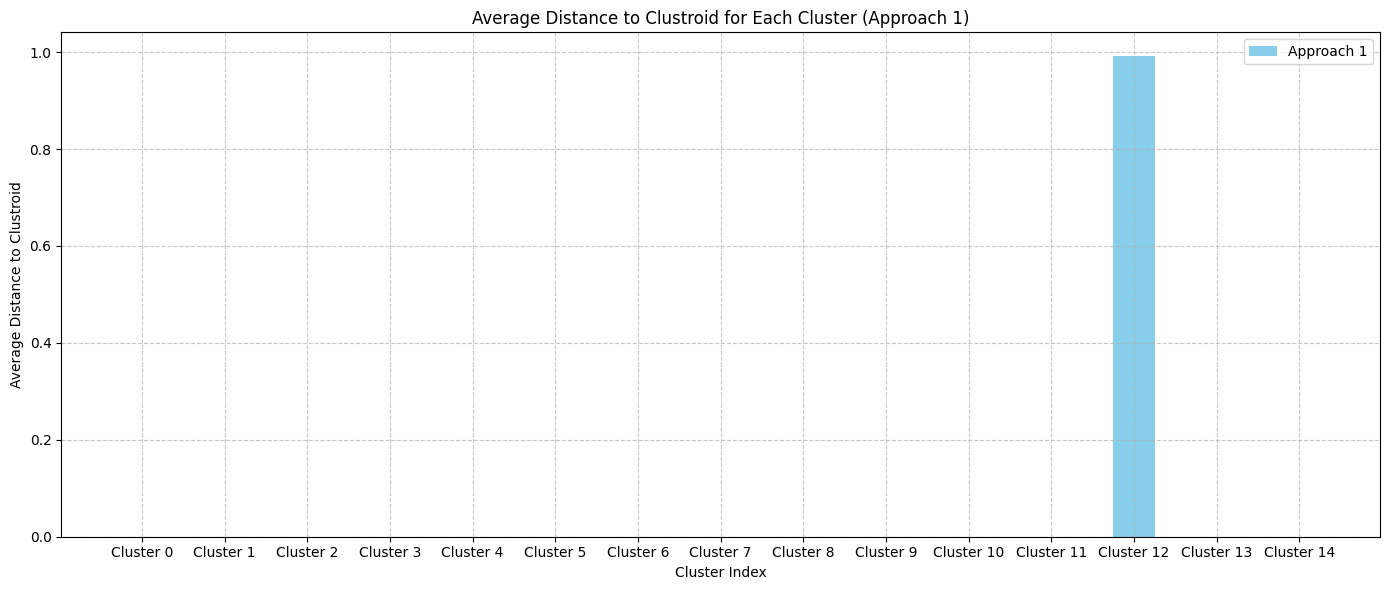

In [13]:
avg_distances1 = agglo.average_distance_to_clustroid()

num_clusters = len(avg_distances1)
clusters = np.arange(num_clusters)
bar_width = 0.5

plt.figure(figsize=(14, 6))
plt.bar(clusters, avg_distances1, bar_width, color='skyblue', label='Approach 1')

plt.xlabel('Cluster Index')
plt.ylabel('Average Distance to Clustroid')
plt.title('Average Distance to Clustroid for Each Cluster (Approach 1)')
plt.xticks(clusters, labels=[f'Cluster {i}' for i in clusters])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig('cluster_distances_approach1.png')
plt.show()